In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wave
import os
from scipy.signal import square, ShortTimeFFT
from scipy.signal.windows import gaussian
from scipy.fft import fft, fftshift
from scipy import signal


In [122]:
df = pd.read_csv('df_unique_first.csv')

In [123]:
df['FileName'] = df['FileName'].str.split('/').str[-1]
df

,FileName,Habitat,Type,Season,Moment
0,KE-US_20200101_000000_MN_1,1,Close,Wet,MN
1,KE-US_20200101_090000_SR_1,1,Close,Wet,SR
2,KE-US_20200101_120000_MD_1,1,Close,Wet,MD
3,KE-US_20200101_150000_SS_1,1,Close,Wet,SS
4,KE-US_20200601_010000_MN_1,1,Close,Dry,MN
...,...,...,...,...,...
67,WD-AU_20150701_16_SS_1,9,Close,Dry,SS
68,WD-AU_20160101_00_MN_1,9,Close,Wet,MN
69,WD-AU_20160101_04_SR_1,9,Close,Wet,SR
70,WD-AU_20160101_11_MD_1,9,Close,Wet,MD


In [124]:
# Max Amp, Min Amp, Power
def add_features(file_path): 
    try:
        with wave.open(file_path, 'rb') as wav_file:
            frames = wav_file.readframes(wav_file.getnframes())
            num_frames = wav_file.getnframes()
            amplitude_array = np.frombuffer(frames, dtype=np.int16)
            max_amp = np.max(amplitude_array)
            min_amp = np.min(amplitude_array)
            power = np.sqrt(np.sum(amplitude_array.astype(np.float64)**2)/num_frames)
            return max_amp, min_amp, power
        
    except wave.Error as e:
        print(f"Error opening {file_path}: {e}")
        return None, None, None

df['Max Amp'] = None
df['Min Amp'] = None
df['Power'] = None

for idx, row in df.iterrows():
    file_name = row['FileName']
    file_path = os.path.join('Selected_WAV_Files', file_name + '.wav')
    max_amp, min_amp, power = add_features(file_path)
    if max_amp is not None and min_amp is not None:
        df.at[idx, 'Max Amp'] = max_amp
        df.at[idx, 'Min Amp'] = min_amp
        df.at[idx, 'Power'] = power

df

,FileName,Habitat,Type,Season,Moment,Max Amp,Min Amp,Power
0,KE-US_20200101_000000_MN_1,1,Close,Wet,MN,1230,-1261,384.001976
1,KE-US_20200101_090000_SR_1,1,Close,Wet,SR,1796,-1493,384.028606
2,KE-US_20200101_120000_MD_1,1,Close,Wet,MD,1728,-1626,384.006116
3,KE-US_20200101_150000_SS_1,1,Close,Wet,SS,1785,-1594,384.021001
4,KE-US_20200601_010000_MN_1,1,Close,Dry,MN,1504,-1491,384.011532
...,...,...,...,...,...,...,...,...
67,WD-AU_20150701_16_SS_1,9,Close,Dry,SS,1218,-1414,384.00682
68,WD-AU_20160101_00_MN_1,9,Close,Wet,MN,1726,-1368,384.000659
69,WD-AU_20160101_04_SR_1,9,Close,Wet,SR,1310,-1625,384.012175
70,WD-AU_20160101_11_MD_1,9,Close,Wet,MD,1463,-1670,384.003758


In [125]:
print(df['Power'].min())
print(df['Power'].max())

383.97729258966575
384.02860626630275


In [126]:
print(df['Min Amp'].min())
print(df['Max Amp'].max())

-7452
8388


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FileName  72 non-null     object
 1   Habitat   72 non-null     int64 
 2   Type      72 non-null     object
 3   Season    72 non-null     object
 4   Moment    72 non-null     object
 5   Max Amp   72 non-null     object
 6   Min Amp   72 non-null     object
 7   Power     72 non-null     object
dtypes: int64(1), object(7)
memory usage: 4.6+ KB


In [128]:
df['Habitat'] = df['Habitat'].astype(str)
df['Season'] = df['Season'].astype(str)
df['Moment'] = df['Moment'].astype(str)

In [129]:
def find_filenames(habitat, season, moment):
    habitat = habitat.strip()
    season = season.strip()
    moment = moment.strip()
    
    df['Habitat'] = df['Habitat'].astype(str).str.lower()
    df['Season'] = df['Season'].astype(str).str.lower()
    df['Moment'] = df['Moment'].astype(str).str.lower()
    
    habitat = habitat.lower()
    season = season.lower()
    moment = moment.lower()

    filtered_df = df[
        ((df['Habitat'] == habitat) | (habitat == '-')) &
        ((df['Season'] == season) | (season == '-')) &
        ((df['Moment'] == moment) | (moment == '-'))
    ]

    print(filtered_df)

    if filtered_df.empty:
        print("No matching records found.")
        return None, None

    file_names = filtered_df['FileName'].tolist()
    habitat_values = filtered_df['Habitat'].tolist()
    season_values = filtered_df['Season'].tolist()
    moment_values = filtered_df['Moment'].tolist()
    return file_names, habitat_values, season_values, moment_values

In [130]:
df

,FileName,Habitat,Type,Season,Moment,Max Amp,Min Amp,Power
0,KE-US_20200101_000000_MN_1,1,Close,Wet,MN,1230,-1261,384.001976
1,KE-US_20200101_090000_SR_1,1,Close,Wet,SR,1796,-1493,384.028606
2,KE-US_20200101_120000_MD_1,1,Close,Wet,MD,1728,-1626,384.006116
3,KE-US_20200101_150000_SS_1,1,Close,Wet,SS,1785,-1594,384.021001
4,KE-US_20200601_010000_MN_1,1,Close,Dry,MN,1504,-1491,384.011532
...,...,...,...,...,...,...,...,...
67,WD-AU_20150701_16_SS_1,9,Close,Dry,SS,1218,-1414,384.00682
68,WD-AU_20160101_00_MN_1,9,Close,Wet,MN,1726,-1368,384.000659
69,WD-AU_20160101_04_SR_1,9,Close,Wet,SR,1310,-1625,384.012175
70,WD-AU_20160101_11_MD_1,9,Close,Wet,MD,1463,-1670,384.003758


22050
<class 'bytes'>
22050
-1652
1620
22050
201
109


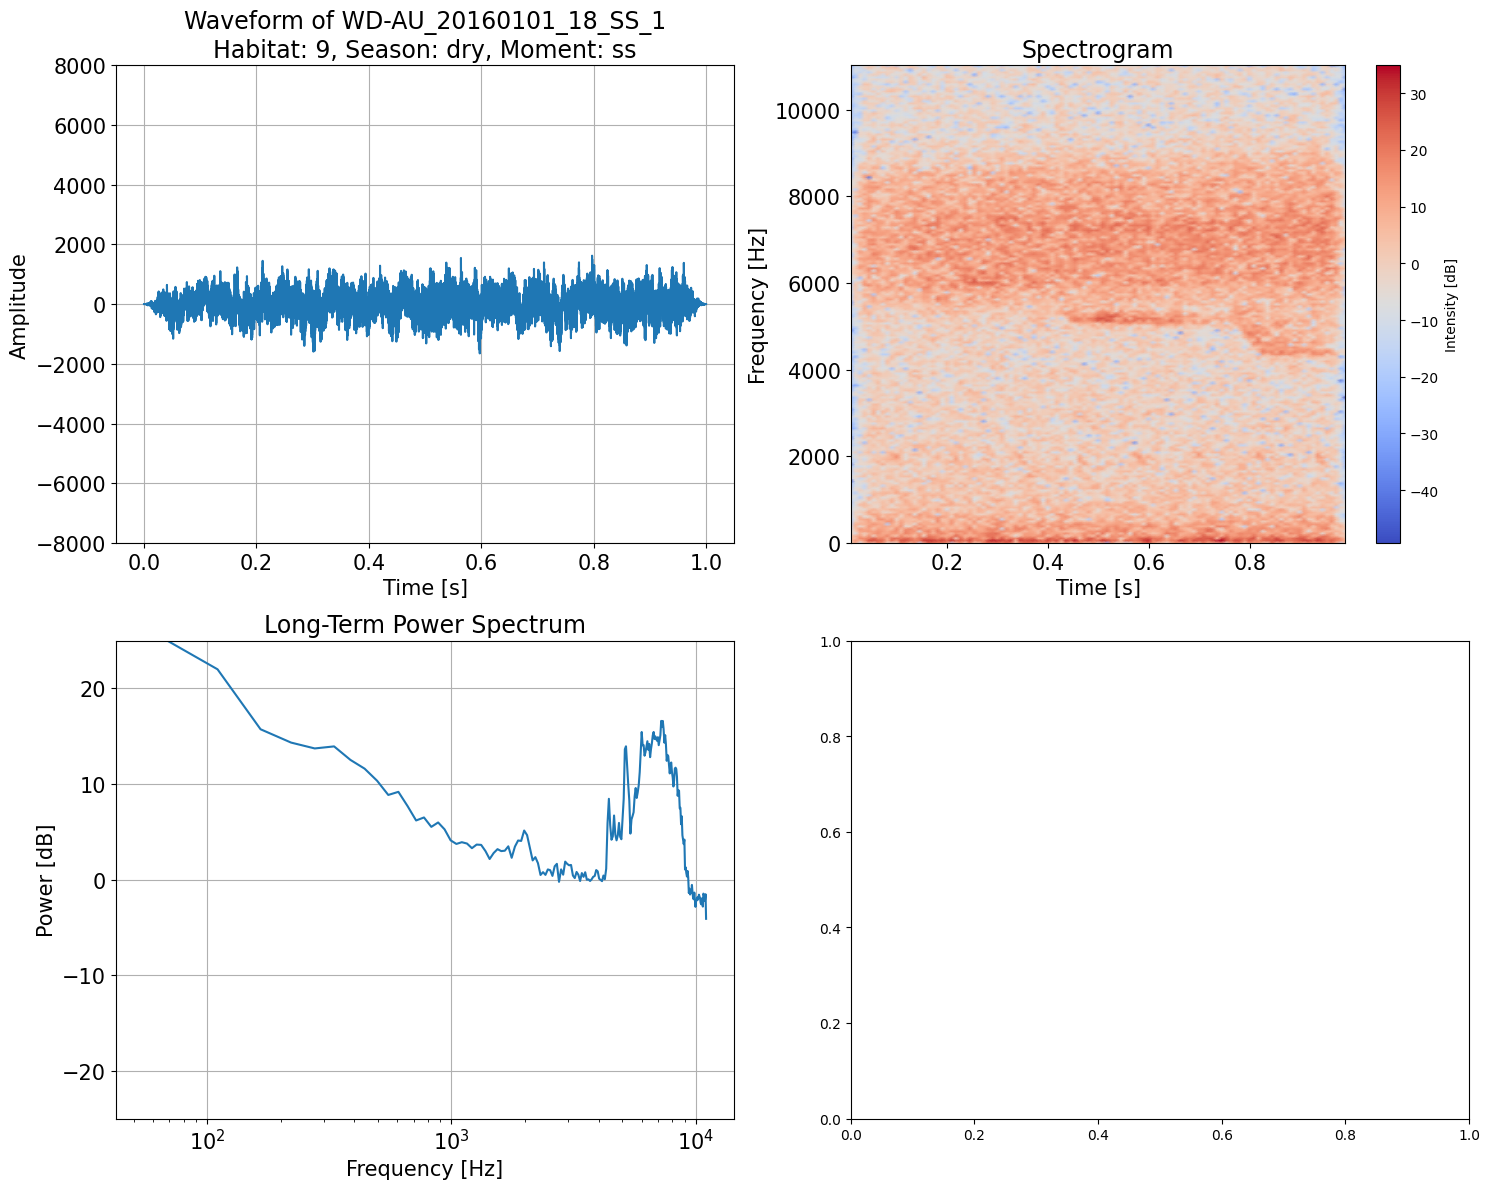

In [132]:
def plot_sound(file_name, habitat_value, season_value, moment_value):
    file_path = os.path.join('Selected_WAV_Files', file_name + '.wav')

    try:
        with wave.open(file_path, 'rb') as wav_file:
            num_frames = wav_file.getnframes()
            print(num_frames)
            
            frames = wav_file.readframes(num_frames) # Reads and returns at most n frames of audio, as a bytes object.
            print(type(frames))

            signal_array = np.frombuffer(frames, dtype=np.int16)
            print(len(signal_array))
            print(signal_array.min())
            print(signal_array.max())
            
            sample_rate = wav_file.getframerate()
            print(sample_rate)

            time_axis = np.linspace(0, num_frames / sample_rate, num=num_frames)

            fig, axs = plt.subplots(2, 2, figsize=(15, 12))

            axs[0, 0].plot(time_axis, signal_array)
            axs[0, 0].set_title(f'Waveform of {file_name}\nHabitat: {habitat_value}, Season: {season_value}, Moment: {moment_value}', fontsize=17)
            axs[0, 0].set_xlabel('Time [s]', fontsize=15)
            axs[0, 0].set_ylabel('Amplitude', fontsize=15)
            axs[0, 0].tick_params(axis='both', labelsize=15)
            axs[0, 0].grid(True)
            axs[0, 0].set_ylim([-8000, 8000])

            # Calculate the spectrogram with a specific window size

            fs = 22050  # Sampling frequency
            nperseg = 400  # Length of each segment
            noverlap = nperseg // 2  # 50% overlap
            
            f, t, Sxx = signal.spectrogram(signal_array, window=('tukey', 0.5), fs=fs, nperseg=nperseg, noverlap=noverlap)

            print(len(f))
            print(len(t))

            # len_t = ((num_frames - noverlap) / (nperseg - noverlap)) + 1
            # print(len_t)
            
            pcm = axs[0, 1].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='coolwarm')
            axs[0, 1].set_title('Spectrogram', fontsize=17)
            axs[0, 1].set_ylabel('Frequency [Hz]', fontsize=15)
            axs[0, 1].set_xlabel('Time [s]', fontsize=15)
            axs[0, 1].tick_params(axis='both', labelsize=15)
            fig.colorbar(pcm, ax=axs[0, 1], label='Intensity [dB]')

            # Compute power spectrum in dB
            power_spectrum = 10 * np.log10(np.mean(Sxx, axis=1) + 1e-10)
            axs[1, 0].semilogx(f, power_spectrum)
            axs[1, 0].set_title('Long-Term Power Spectrum', fontsize=17)
            axs[1, 0].set_xlabel('Frequency [Hz]', fontsize=15)
            axs[1, 0].set_ylabel('Power [dB]', fontsize=15)
            axs[1, 0].tick_params(axis='both', labelsize=15)
            axs[1, 0].grid(True)
            axs[1, 0].set_ylim([-25, 25])

            # log_amplitude = np.log(Sxx + 1e-10)
            # MPS_full = np.abs(np.fft.fftshift(np.fft.fft2(log_amplitude)))

            # # Only consider the positive frequencies of the MPS
            # # print(MPS_full)

            # nyquist_index = MPS_full.shape[0] // 2
            # MPS_positive = MPS_full[nyquist_index:, :]

            # # Plot only the positive part of the MPS using a 'plasma' colormap
            # axs[1, 1].imshow(MPS_full, aspect='auto', origin='lower',
            #                  cmap='plasma', interpolation='bilinear')
            # axs[1, 1].set_title('Modulation Power Spectrum (Positive Frequencies)', fontsize=15)
            # axs[1, 1].set_xlabel('Modulation Frequency [Hz]', fontsize=15)
            # axs[1, 1].set_ylabel('Modulation Frequency [Hz]', fontsize=15)
            # axs[1, 1].tick_params(labelsize=15)

            plt.tight_layout()
            plt.show()
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        return
# Example   
plot_sound(file_name, '9', 'dry', 'ss')


C:\Users\aslan\AppData\Local\Temp\ipykernel_6288\1047035436.py:11: RuntimeWarning: divide by zero encountered in log10
  response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))


Text(0.5, 0, 'Normalized frequency [cycles per sample]')

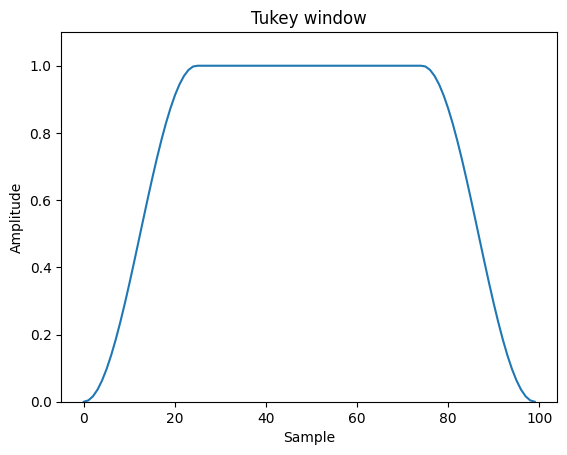

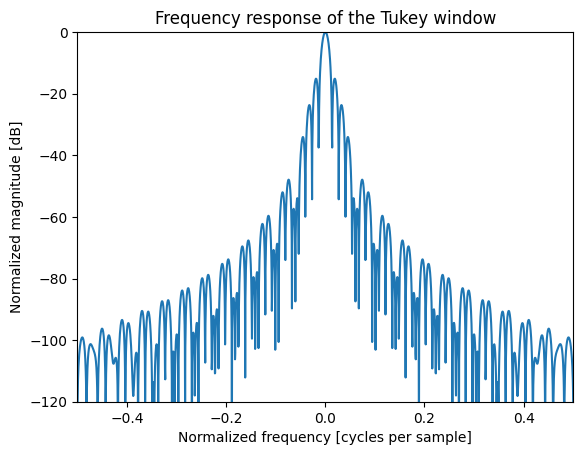

In [166]:
window = signal.windows.tukey(100, alpha=0.5)
plt.plot(window)
plt.title("Tukey window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.ylim([0, 1.1])
plt.figure()

A = fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the Tukey window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")

# Get Input

In [135]:
habitat = input("Enter Habitat (or '-' for all): ")
season = input("Enter Season (or '-' for all): ")
moment = input("Enter Moment (or '-' for all): ")

file_names, habitat_values, season_values, moment_values = find_filenames(habitat, season, moment)

if file_names:
    print("Plotting waveforms for the following files:")
    for i, file_name in enumerate(file_names):
        print(f"- {file_name}")                                                                         
        plot_sound(file_name, habitat_values[i], season_values[i], moment_values[i])

In [156]:
import os
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.signal import spectrogram

def plot_sound(file_name, habitat_value, season_value, moment_value):
    file_path = os.path.join('Selected_WAV_Files', file_name + '.wav')

    try:
        with wave.open(file_path, 'rb') as wav_file:
            num_frames = wav_file.getnframes()
            frames = wav_file.readframes(num_frames)
            signal_array = np.frombuffer(frames, dtype=np.int16)
            sample_rate = wav_file.getframerate()

            # Compute the spectrogram
            nperseg = 500
            noverlap = nperseg // 2
            f, t, Sxx = spectrogram(signal_array, fs=sample_rate, window=('tukey', 0.5), nperseg=nperseg, noverlap=noverlap)

            # Plot the spectrogram
            plt.figure(figsize=(15, 8))
            pcm = plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='coolwarm')
            plt.title('Spectrogram', fontsize=17)
            plt.ylabel('Frequency [Hz]', fontsize=15)
            plt.xlabel('Time [s]', fontsize=15)
            plt.tick_params(axis='both', labelsize=15)
            plt.colorbar(pcm, label='Intensity [dB]')
            
            # Save the plot to a file, including the nperseg value in the filename
            output_filename = f"{file_name}_nperseg{nperseg}.jpg"
            plt.tight_layout()
            plt.savefig(output_filename, format='jpg')
            plt.close()

    except FileNotFoundError:
        print(f"File {file_path} not found.")

habitat = input("Enter Habitat (or '-' for all): ")
season = input("Enter Season (or '-' for all): ")
moment = input("Enter Moment (or '-' for all): ")

file_names, habitat_values, season_values, moment_values = find_filenames(habitat, season, moment)

if file_names:
    print("Plotting waveforms for the following files:")
    for i, file_name in enumerate(file_names):
        print(f"- {file_name}")                                                                         
        plot_sound(file_name, habitat_values[i], season_values[i], moment_values[i])


                      FileName Habitat   Type Season Moment Max Amp Min Amp  \
0   KE-US_20200101_000000_MN_1       1  Close    wet     mn    1230   -1261   
1   KE-US_20200101_090000_SR_1       1  Close    wet     sr    1796   -1493   
2   KE-US_20200101_120000_MD_1       1  Close    wet     md    1728   -1626   
3   KE-US_20200101_150000_SS_1       1  Close    wet     ss    1785   -1594   
4   KE-US_20200601_010000_MN_1       1  Close    dry     mn    1504   -1491   
..                         ...     ...    ...    ...    ...     ...     ...   
67      WD-AU_20150701_16_SS_1       9  Close    dry     ss    1218   -1414   
68      WD-AU_20160101_00_MN_1       9  Close    wet     mn    1726   -1368   
69      WD-AU_20160101_04_SR_1       9  Close    wet     sr    1310   -1625   
70      WD-AU_20160101_11_MD_1       9  Close    wet     md    1463   -1670   
71      WD-AU_20160101_18_SS_1       9  Close    wet     ss    1620   -1652   

         Power  
0   384.001976  
1   384.028606  


In [158]:
import cv2
import os
import glob

# Specify the directory containing images
image_folder = '.'

# Gather all filenames, assuming .jpg extension (adjust as needed)
image_files = glob.glob(os.path.join(image_folder, '*.jpg'))

# Sort filenames (you might need to adjust sorting based on your naming convention)
image_files.sort()

# Ensure there are images to process
if not image_files:
    print("No images found to create a video.")
else:
    # Get the width and height of the images
    frame = cv2.imread(image_files[0])
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object (e.g., using XVID codec)
    video_filename = 'output_video.avi'
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(video_filename, fourcc, 1.0, (width, height))

    # Iterate over images and write them to video
    for image_file in image_files:
        print(f'Adding {image_file} to video')
        image = cv2.imread(image_file)
        out.write(image)  # Write the image to the video

    # Release the video writer
    out.release()
    print(f"Video saved as {video_filename}")


Adding .\CS-BR_20170101_010000_MN_1_nperseg200.jpg to video
Adding .\CS-BR_20170101_010000_MN_1_nperseg300.jpg to video
Adding .\CS-BR_20170101_010000_MN_1_nperseg400.jpg to video
Adding .\CS-BR_20170101_010000_MN_1_nperseg500.jpg to video
Adding .\CS-BR_20170101_060000_SR_1_nperseg200.jpg to video
Adding .\CS-BR_20170101_060000_SR_1_nperseg300.jpg to video
Adding .\CS-BR_20170101_060000_SR_1_nperseg400.jpg to video
Adding .\CS-BR_20170101_060000_SR_1_nperseg500.jpg to video
Adding .\CS-BR_20170101_120000_MD_1_nperseg200.jpg to video
Adding .\CS-BR_20170101_120000_MD_1_nperseg300.jpg to video
Adding .\CS-BR_20170101_120000_MD_1_nperseg400.jpg to video
Adding .\CS-BR_20170101_120000_MD_1_nperseg500.jpg to video
Adding .\CS-BR_20170101_190000_SS_1_nperseg200.jpg to video
Adding .\CS-BR_20170101_190000_SS_1_nperseg300.jpg to video
Adding .\CS-BR_20170101_190000_SS_1_nperseg400.jpg to video
Adding .\CS-BR_20170101_190000_SS_1_nperseg500.jpg to video
Adding .\CS-BR_20170801_000000_MN_1_nper